# Prototyping Settings for Simplistic DESC SRD Y1 after PGD implementation 

For reference, the DESC SRD can be found [here](https://arxiv.org/pdf/1809.01669.pdf). Appendix D2 specifies some of the analysis choices for the Y1 data. 

In particular:
- neff for lensing sources: 10 gal/arcmin^2
- sigma_e: 0.26 per component
- lmax: 3000


In this notebook, we will see the effects of the PGD implemantion and scale resolution factor B=2 on the angular power spectrum. \
We will use a kappa TNG map as a reference point.

In [1]:
%pylab inline 
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
import flowpm.scipy.interpolate as interpolate
import pickle
from flowpm import tfpm
import jax_cosmo as jc
import jax_cosmo.power as power
from DifferentiableHOS.pk import pk as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
n_lens = 20
box_size= 128.     
nc=128
field_size = 5.   
field_npix = 1024
B=2
batch_size = 1 
z_source = np.array([1.])

In [3]:
cosmology = flowpm.cosmology.Planck15()
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
init_stages = tf.linspace(0.1, a[-1], 20)
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)


In [4]:
k = tf.constant(np.logspace(-4, 1, 512), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(
      [nc, nc, nc],
      [box_size, box_size, box_size],
      pk_fun,
      batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [5]:
states = flowpm.nbody(cosmology,
                        initial_state,
                    stages, [nc, nc, nc],
                    pm_nc_factor=B,
                    return_intermediate_states=True)

# Implementation of PGD

The following parameters of PGD are selected from the following [notebook](https://github.com/VMBoehm/MADLens/blob/3d024515098bb591e5c7f7b4e34b7e1903f8c3ab/notebooks/PGD_params.ipynb) by [Boehm et al. 2020](https://arxiv.org/abs/2012.07266)\
Only the alpha0 parameter is selected after the calibration computed in our [notebook](https://github.com/DifferentiableUniverseInitiative/flowpm/blob/09352ec99a96cfd52e6b7bee2c433eea6f962360/notebooks/dev/PGD_test.ipynb)


In [6]:
PGD_param=pickle.load( open("/global/u1/d/dlan/flowpm/notebooks/pgd_params/pgd_params_2_1_40.pkl", "rb" ) )

In [7]:
alpha0=0.01
mu=PGD_param['mu']
kl=PGD_param['kl']*0.7*0.5/(nc*B/ box_size)
ks=PGD_param['ks']*0.7*0.5/(nc*B/ box_size)

Let's compute the displacement

In [8]:
dx=[]
for i in range(len(states)):
    alpha=alpha0*states[i][0]**mu
    dx.append(tfpm.PGD_correction(states[i][1],[nc,nc,nc],alpha,kl,ks,pm_nc_factor=B))


In [11]:
cosmo=jc.Planck15()

Check that everything works properly comparing the matter power spectrum to theoretical one 

In [13]:
new_states=[]
pk_array=[]
pk_array1=[]
pk_jax=[]
for i in range(len(states)):
    new_states.append(dx[i]+states[i][1][0])
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_states[i])
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                             box_size]),kmin=0.1,dk=2*np.pi/box_size)
    final_field1 = flowpm.cic_paint(tf.zeros_like(initial_conditions), states[i][1][0])
    final_field1=tf.reshape(final_field1, [nc, nc, nc])
    k1, power_spectrum1 = pkl(final_field1,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                         box_size]),kmin=0.1,dk=2*np.pi/box_size)
    pk_array.append(power_spectrum)
    pk_jax.append(power.nonlinear_matter_power(cosmo, k, states[i][0]))
    pk_array1.append(power_spectrum1)
    

In [14]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

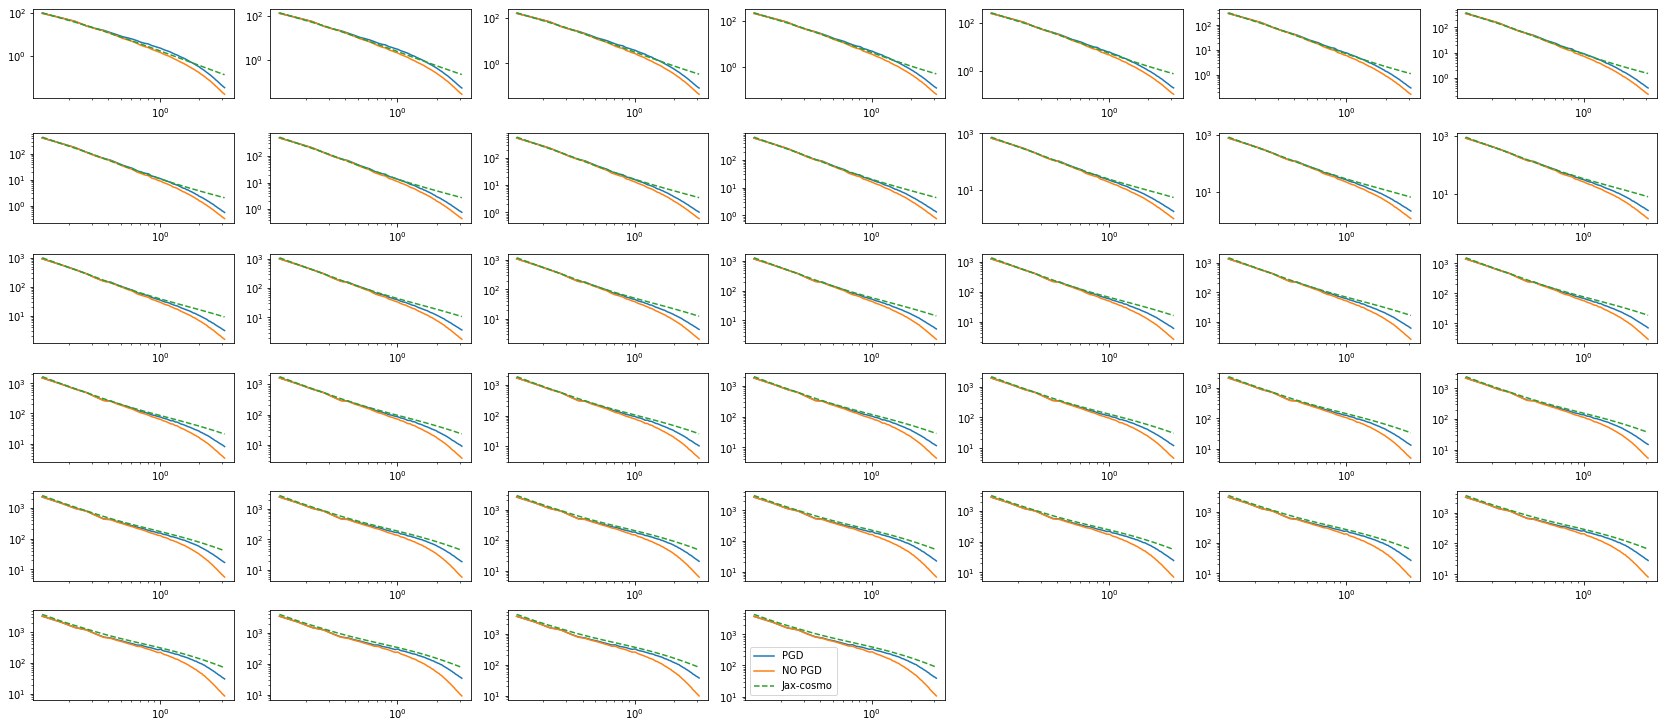

In [15]:
figsize = (23, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 7
rows =6
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(pk_array))

for ax, pi in zip(axs, pk_array):
    ax.loglog(k, pi,label='PGD')
for ax, px in zip(axs, pk_array1):
    ax.loglog(k, px,label='NO PGD')
for ax, pj in zip(axs, pk_jax):
    ax.loglog(k, pj,'--',label='Jax-cosmo')
legend(loc='lower left')


Implement the raytracing

In [16]:
lensplanes = []
lensplanes1 = []
for i in range(len(a_center)):
    plane = flowpm.raytracing.density_plane(new_states[::-1][i],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=256,
                                            shift=flowpm.raytracing.random_2d_shift())
    plane1 = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=256,
                                            shift=flowpm.raytracing.random_2d_shift())
    
    plane = tf.expand_dims(plane, axis=-1)
    plane = tf.image.random_flip_left_right(plane)
    plane = tf.image.random_flip_up_down(plane)
    plane1 = tf.expand_dims(plane1, axis=-1)
    plane1 = tf.image.random_flip_left_right(plane1)
    plane1 = tf.image.random_flip_up_down(plane1)
    lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))
    lensplanes1.append((r_center[i], states[::-1][i][0], plane1[...,0]))


In [17]:
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)


m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m1 = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes1, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)


m = m.numpy().reshape([batch_size, field_npix, field_npix])
m1 = m1.numpy().reshape([batch_size, field_npix, field_npix])

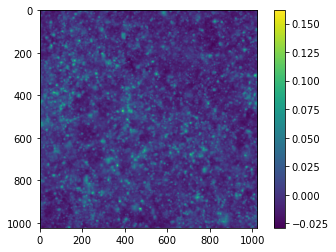

In [18]:
imshow(m[0])
colorbar()

In [19]:
l, ps= DHOS.statistics.power_spectrum(m[0],field_size,field_npix)
l1, ps1= DHOS.statistics.power_spectrum(m1[0],field_size,field_npix)

In [20]:
nz =jc.redshift.delta_nz(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


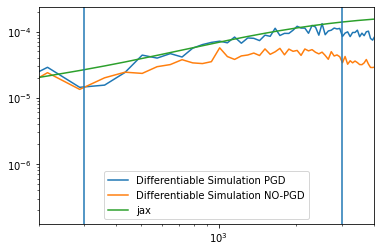

In [22]:
loglog(l, l*(l+1)*ps/(2*np.pi),label='Differentiable Simulation PGD ')
loglog(l, l*(l+1)*ps1/(2*np.pi),label='Differentiable Simulation NO-PGD')
loglog(l, l*(l+1)*cls[0]/(2*np.pi),label='jax')
xlim(2e2,4e3)
axvline(300)
axvline(3000)
legend()
#savefig('cl_comp.png',dpi=250)

## Comparison to kappa TNG

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [23]:
kTNG = np.load('kappa_tng.npy')

So, obvioulsy our 128^3 simulation is not as precise as kappa TNG, but we won't be working at the native 0.3 arcmin resolution anyway, in practice we'll have noise and smoothing.

So let's see how much smoothing gets us in the right ball park.

In [24]:
ngal = 10                          # gal/arcmin **2
pix_scale = 5/1024*60              # arcmin
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels (I think)
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [25]:
sigma_pix=1/pix_scale

In [26]:
l, ps_FLP= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(m[0],11,sigma=sigma_pix),field_size,field_npix)

In [27]:
l, ps_TNG=DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kTNG,11,sigma=sigma_pix),field_size,field_npix)

In [28]:
l, ps_FLP_NOPGD= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(m1[0],11,sigma=sigma_pix),field_size,field_npix)

In [29]:
l1= tf.where(l < 9000, False, True)
l = tf.boolean_mask(l, tf.math.logical_not(l1))
ps_FLP = tf.boolean_mask(ps_FLP, tf.math.logical_not(l1))
ps_TNG = tf.boolean_mask(ps_TNG, tf.math.logical_not(l1))
ps_FLP_NOPGD = tf.boolean_mask(ps_FLP_NOPGD, tf.math.logical_not(l1))

In [30]:
def rebin(a, shape):
    sh = shape,a.shape[0]//shape
    return tf.math.reduce_mean(tf.reshape(a,sh),axis=-1)

In [31]:
l=rebin(l,25)
ps_FLP=rebin(ps_FLP,25)
ps_TNG=rebin(ps_TNG,25)
ps_FLP_NOPGD=rebin(ps_FLP_NOPGD,25)

Text(0.5, 1.0, 'Comparison to kappaTNG')

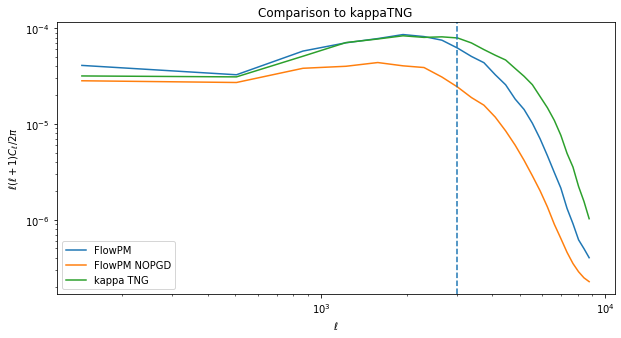

In [32]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP/(2*np.pi), label='FlowPM')
loglog(l, l*(l+1)*ps_FLP_NOPGD/(2*np.pi), label='FlowPM NOPGD')
loglog(l, l*(l+1)*ps_TNG/(2*np.pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG')

## Adding noise

We'll now try to get to a realistic setting that matches some of the SRD Y1 settings.

In [33]:
knTNG_n = np.load('kappa_tng.npy')+ sigma_e * randn(1024,1024), 5*u.deg
knFPM_n = m[0]+ sigma_e * randn(1024,1024), 5*u.deg
knFPM_n_NOPGD = m1[0]+ sigma_e * randn(1024,1024), 5*u.deg

In [34]:
l, ps_FLP= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(knFPM_n[0],11,sigma=sigma_pix),field_size,field_npix)

In [35]:
l, ps_FLP_NOPGD= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(knFPM_n_NOPGD[0],11,sigma=sigma_pix),field_size,field_npix)

In [36]:
l, ps_TNG=DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(knTNG_n[0],11,sigma=sigma_pix),field_size,field_npix)

In [37]:
l1= tf.where(l < 9000, False, True)
l = tf.boolean_mask(l, tf.math.logical_not(l1))
ps_FLP = tf.boolean_mask(ps_FLP, tf.math.logical_not(l1))
ps_TNG = tf.boolean_mask(ps_TNG, tf.math.logical_not(l1))
ps_FLP_NOPGD=tf.boolean_mask(ps_FLP_NOPGD, tf.math.logical_not(l1))

In [38]:
l=rebin(l,25)
ps_FLP=rebin(ps_FLP,25)
ps_TNG=rebin(ps_TNG,25)
ps_FLP_NOPGD=rebin(ps_FLP_NOPGD,25)

Text(0.5, 1.0, 'Comparison to kappaTNG')

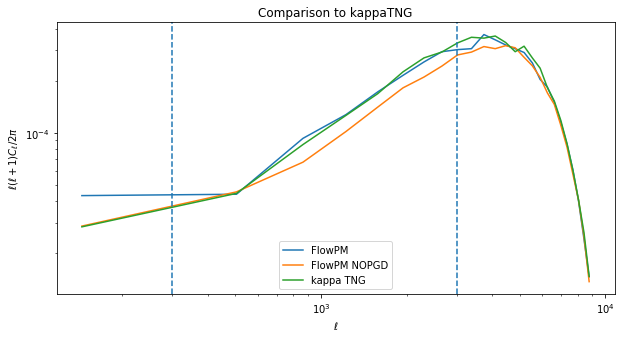

In [39]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP/(2*np.pi), label='FlowPM')
loglog(l, l*(l+1)*ps_FLP_NOPGD/(2*np.pi), label='FlowPM NOPGD')
loglog(l, l*(l+1)*ps_TNG/(2*np.pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
axvline(300,ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG')



(200.0, 4000.0)

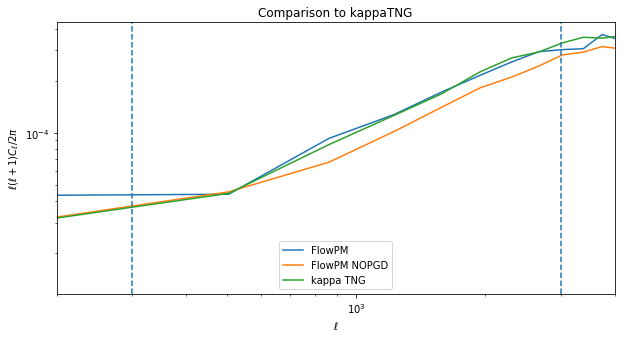

In [40]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP/(2*np.pi), label='FlowPM')
loglog(l, l*(l+1)*ps_FLP_NOPGD/(2*np.pi), label='FlowPM NOPGD')
loglog(l, l*(l+1)*ps_TNG/(2*np.pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
axvline(300,ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG')
xlim(2e2,4e3)
